In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('/home/quantum/Documents/iltpe/SiO2Damon1973.txt', 'r') as f:
    data = f.readlines()
data = [d.split('\t') for d in data]
data = pd.DataFrame(data[1:], columns=['T', 'k'])
data['k'] = data['k'].str.replace('\n', '')
for c in data.columns:
    data[c] = data[c].astype('float')

In [3]:
data['T_log'] = np.log(data['T'])
data['k_log'] = np.log(data['k'])

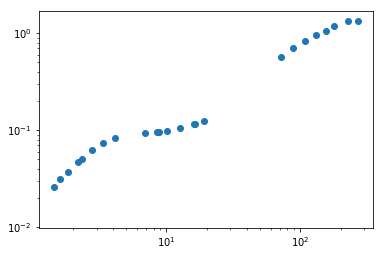

In [4]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(data['T'], data['k'])
ax.set_yscale('log')
ax.set_xscale('log')

In [5]:
z = np.polyfit(data['T_log'], data['k_log'], 6)
p = np.poly1d(z)
xp = np.linspace(0, 5, 100)
ap_df = pd.DataFrame({'x':xp})
ap_df['y'] = [p(x) for x in xp]

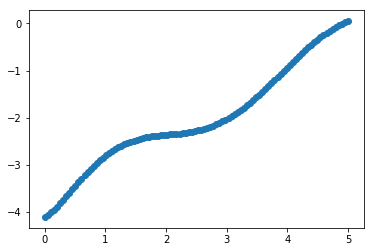

In [6]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(ap_df['x'], ap_df['y'])
# ax.set_yscale('log')
# ax.set_xscale('log')

In [7]:
ap_df.head()

,x,y
0,0.000000,-4.109610
1,0.050505,-4.062483
2,0.101010,-4.008089
3,0.151515,-3.947676
4,0.202020,-3.882392


In [8]:
def k_func(T, c1, c2, c3, c4, n):
    k1 = (c1*T**n*c2)/(c1*T**n+c2) 
    k2 = c3*np.exp(-(c4/T))
    return k1+k2

def loss_k(params):
    c1 = params['c1']  
    c2 = params['c2'] 
    c3 = params['c3'] 
    c4 = params['c4']
    n = params['n']
    k_fit = [k_func(t, c1, c2, c3, c4, n) for t in T]
    return np.mean((k_fit - k)**2)

In [9]:
T = ap_df['x']+0.01
k = ap_df['y']

In [10]:
test_params = {
    'c1':0.01,
    'c2':15,
    'c3':0.01,
    'c4':5,
    'n':2
}
loss_k(test_params)

5.459094069513787

In [11]:
from hyperopt import fmin, tpe, hp
space = {'c1': hp.uniform('c1', 0.01, 0.1),
        'c2': hp.uniform('c2', 0.0001, 15),
        'c3': hp.uniform('c3', 0.1, 100),
        'c4': hp.uniform('c4', 5, 250),
        'n': hp.uniform('n', 1.7, 2)}

best = fmin(fn=loss_k,
    space=space,
    algo=tpe.suggest,
    max_evals=500)
print(best)


100%|██████████| 500/500 [00:06<00:00, 60.07it/s, best loss: 5.265866923174254] 
{'c1': 0.06533284299348534, 'c2': 0.001403852524809518, 'c3': 45.95370063953297, 'c4': 156.20535686203047, 'n': 1.8165968531815446}


In [12]:
best

{'c1': 0.06533284299348534,
 'c2': 0.001403852524809518,
 'c3': 45.95370063953297,
 'c4': 156.20535686203047,
 'n': 1.8165968531815446}

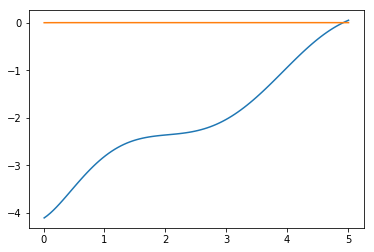

In [13]:
c1 = best["c1"]
c2 = best["c2"]
c3 = best["c3"]
c4 = best["c4"]
n = best["n"]
k1_fitted = k_func(T, c1, c2, c3, c4, n)
plt.plot(T, k)
plt.plot(T, k1_fitted)

In [14]:
z = np.polyfit(data['T_log'], data['k_log'], 6)
p = np.poly1d(z)
xp = np.linspace(0, 5, 100)
ap_df = pd.DataFrame({'x':xp})